# HW05: linear regressions

**DEADLINE: Wednesday, November 5th, 2025**

# Preliminaries

## Import needed python packages

In [2]:
from matplotlib import pyplot as plt  # for plotting
import numpy as np # for working with arrays of numerical values
import pandas as pd # for reading CSV or excel files and subsequent analyses
import scipy  # for various scientific calculations
import xarray as xr  # for loading data and subsequent analyses

## Load the Central Park data

In [3]:
!pip install pooch

# The above command installs the needed `pooch` 3rd-party package if it's not already installed.


import hashlib  # for verifying that the Central Park file is not corrupted
import pathlib  # for constructing paths to the dataset's location on disk
import sys  # for checking if this is a Google Colab session or not
import pooch  # for downloading the dataset from the web, if needed


# Replace "../data" as needed to point to the correct directory for you.
# This can be an *absolute path* or a *relative path*.  One dot, `.`, means
# "this directory", while two dots, `..`, means "go up one directory."
LOCAL_DATA_DIR = "../data"  # If you're in Colab: just ignore this.

# The URL where the dataset can be downloaded from.
DATA_URL = (
    "https://spencerahill.github.io/25f-stat-methods-course/_downloads/"
    "91803b82950d49961a65355c075439b3/central-park-station-data_1869-01-01_2023-09-30.nc"
)

# This HASH_HEX stores a "hash" which we use to verify that the data you end up
# with has not been altered or corrupted compared to the one at the above URL.
HASH_HEX = "85237a4bae1202030a36f330764fd5bd0c2c4fa484b3ae34a05db49fe7721eee"


def create_data_path(
    colab_dir="/content/data", 
    local_dir=LOCAL_DATA_DIR,
    filename="central-park-station-data_1869-01-01_2023-09-30.nc",
):
    """Set the path for the data, whether on colab or a local Jupyter session."""
    is_this_a_colab = "google.colab" in sys.modules
    if is_this_a_colab:
        data_dir = colab_dir 
    else: 
        data_dir = local_dir

    DATA_DIR = pathlib.Path(data_dir)
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    return DATA_DIR / filename


def sha256sum(path: pathlib.Path) -> str:
    """Get the hash of the file at the specified path."""
    return hashlib.sha256(path.read_bytes()).hexdigest()


DATA_PATH = create_data_path()
# Determine if we'll need to download the data, which we'll do if either (a) 
# the data can't be found, or (b) it appears corrupted/modified from the
# "master" file at the above URL.
need_fetch = (not DATA_PATH.exists()) or (sha256sum(DATA_PATH) != HASH_HEX)

# Download the data if needed.
if need_fetch:
    fetched_data = pooch.retrieve(
        url=DATA_URL, 
        known_hash=f"sha256:{HASH_HEX}",
        path=DATA_PATH.parents[0], 
        fname=DATA_PATH.name,
    )
    print(f"\nDownloaded and verified: {fetched_data}")
else:
    print(f"\nVerified existing file at {DATA_PATH}")

Looking in links: https://pypi.python.org/pypi, https://testpypi.python.org/pypi

Verified existing file at ../data/central-park-station-data_1869-01-01_2023-09-30.nc


In [4]:
import xarray as xr

# `DATA_PATH` variable was created by the hidden cell just above. 
# Un-hide that cell if you want to see the details.
ds_cp = xr.open_dataset(DATA_PATH)
ds_cp

<xarray.Dataset> Size: 5MB
Dimensions:        (time: 56520)
Coordinates:
  * time           (time) datetime64[ns] 452kB 1869-01-01 ... 2023-09-30
Data variables:
    temp_max       (time) int64 452kB ...
    temp_min       (time) int64 452kB ...
    temp_avg       (time) float64 452kB ...
    temp_anom      (time) float64 452kB ...
    heat_deg_days  (time) int64 452kB ...
    cool_deg_days  (time) int64 452kB ...
    precip         (time) float64 452kB ...
    snow_fall      (time) float64 452kB ...
    snow_depth     (time) int64 452kB ...

# Compute and analyze linear regressions

Compute each of the following regressions ("Y against X" means you regress Y onto X):

- [ ] annual block maximum precipitation against daily mean temperature averaged over May through September of each year
- [ ] snow fall against daily maximum temperature, both restricting to days in December through February
- [ ] same, but also restricting to days with nonzero snowfall

For each of these, include each of the following:

- [ ] the Pearson correlation coefficient
- [ ] the regression slope value, including the units
- [ ] the regression intercept value, including the units
- [ ] a scatterplot of the two variables with the regression line overlaid
- [ ] a ~2 sentence analysis of your interpretation of the results of the regression

## Annual max P vs. MJJAS mean T

In [13]:
ann_max_p = ds_cp["precip"].groupby("time.year").max()

mjjas_temp = ds_cp["temp_avg"].where(ds_cp["time"].dt.month.isin([5,6,7,8,9]), drop=True)
mjjas_temp_avg = mjjas_temp.groupby("time.year").mean()

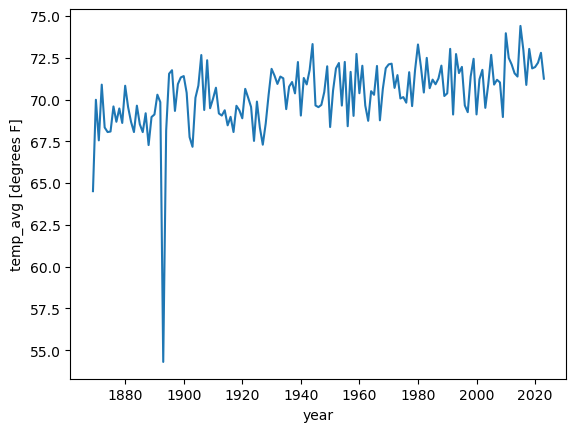

In [14]:
mjjas_temp_avg.plot()

In [15]:
mjjas_temp_avg.idxmin("year")

<xarray.DataArray 'year' ()> Size: 8B
array(1893.)

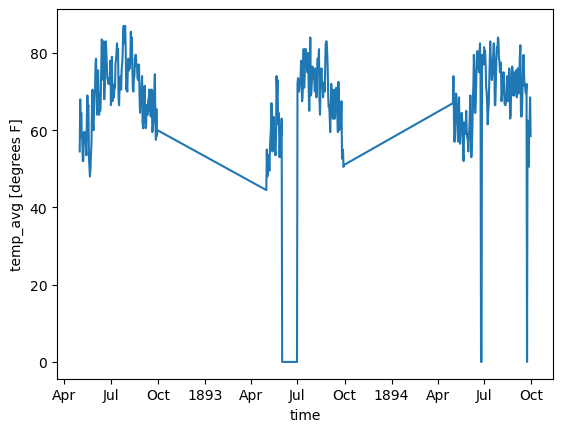

In [20]:
mjjas_temp.sel(time=slice("1892", "1894")).plot()

In [27]:
mjjas_temp_valid = mjjas_temp.where(mjjas_temp != 0)
mjjas_temp_valid_avg = mjjas_temp_valid.groupby("time.year").mean()

In [28]:
lr_maxp_mjjast = scipy.stats.linregress(mjjas_temp_valid_avg, ann_max_p)
lr_maxp_mjjast

LinregressResult(slope=np.float64(0.02419050995226056), intercept=np.float64(1.454334061352404), rvalue=np.float64(0.029678230117972035), pvalue=np.float64(0.7139316747613376), stderr=np.float64(0.06586731545948786), intercept_stderr=np.float64(4.642193985665543))

Text(0, 0.5, 'ann max P [inches]')

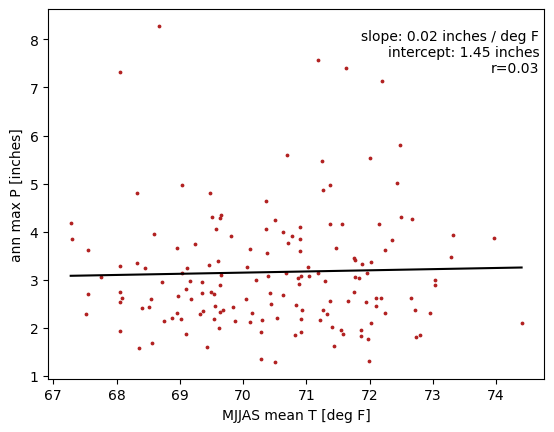

In [38]:
fig, ax = plt.subplots()
ax.scatter(mjjas_temp_valid_avg, ann_max_p, s=3, c="firebrick")
ax.plot(
    [mjjas_temp_valid_avg.min(), mjjas_temp_valid_avg.max()], 
    [lr_maxp_mjjast.slope * mjjas_temp_valid_avg.min() + lr_maxp_mjjast.intercept,
     lr_maxp_mjjast.slope * mjjas_temp_valid_avg.max() + lr_maxp_mjjast.intercept], 
    color="black")

label_text = f"""
slope: {lr_maxp_mjjast.slope:.02f} inches / deg F
intercept: {lr_maxp_mjjast.intercept:.02f} inches
r={lr_maxp_mjjast.rvalue:.02f}
"""

ax.text(0.99, 0.99, label_text, ha="right", va="top", transform=ax.transAxes)

ax.set_xlabel("MJJAS mean T [deg F]")
ax.set_ylabel("ann max P [inches]")

**Interpretation**: the relationship between these two variables is very weak...the correlation coefficient is approximately zero, and the regression slope is too.  This suggests that the annual maximum rainfall is not strongly determined by the average temperatures over the warmest 5 months of the year.

(See [this paper](https://www.nature.com/articles/s41598-024-78704-9) however, which shows that annual max *hourly* precip at Central Park *does* have a significant relationship with a different variable, namely the sum of the *cooling degree days* from May through October.)

## Daily snowfall vs. max T, December through February

In [51]:
ds_djf = ds_cp.where(ds_cp["time"].dt.month.isin([1,2,12]), drop=True)
ds_djf = ds_djf.where(ds_djf["temp_max"] != 0, drop=True)
ds_djf

<xarray.Dataset> Size: 1MB
Dimensions:        (time: 13944)
Coordinates:
  * time           (time) datetime64[ns] 112kB 1869-01-01 ... 2023-02-28
Data variables:
    temp_max       (time) float64 112kB 29.0 27.0 35.0 37.0 ... 50.0 46.0 38.0
    temp_min       (time) float64 112kB 19.0 21.0 27.0 34.0 ... 30.0 33.0 32.0
    temp_avg       (time) float64 112kB 24.0 24.0 31.0 35.5 ... 40.0 39.5 35.0
    temp_anom      (time) float64 112kB -11.2 -11.0 -3.8 0.8 ... 1.9 1.2 -3.5
    heat_deg_days  (time) float64 112kB 41.0 41.0 34.0 29.0 ... 25.0 25.0 30.0
    cool_deg_days  (time) float64 112kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    precip         (time) float64 112kB 0.75 0.03 0.0 0.18 ... 0.0 0.0 0.21 0.34
    snow_fall      (time) float64 112kB 9.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.9 0.9
    snow_depth     (time) float64 112kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 2.0

In [52]:
lr_snow_tmax = scipy.stats.linregress(ds_djf["temp_max"], ds_djf["snow_fall"], nan_policy="omit")
lr_snow_tmax

LinregressResult(slope=np.float64(-0.021885558129581102), intercept=np.float64(1.154771006053041), rvalue=np.float64(-0.18752169322826787), pvalue=np.float64(4.0507063864523685e-99), stderr=np.float64(0.0010263901996679127), intercept_stderr=np.float64(0.04276606845704231))

Text(0, 0.5, 'daily snow fall [inches]')

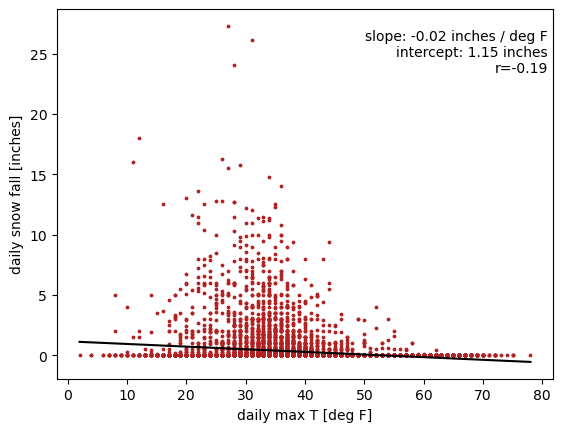

In [53]:
fig, ax = plt.subplots()
ax.scatter(ds_djf["temp_max"], ds_djf["snow_fall"], s=3, c="firebrick")
ax.plot(
    [ds_djf["temp_max"].min(), ds_djf["temp_max"].max()], 
    [lr_snow_tmax.slope * ds_djf["temp_max"].min() + lr_snow_tmax.intercept,
     lr_snow_tmax.slope * ds_djf["temp_max"].max() + lr_snow_tmax.intercept], 
    color="black")

label_text = f"""
slope: {lr_snow_tmax.slope:.02f} inches / deg F
intercept: {lr_snow_tmax.intercept:.02f} inches
r={lr_snow_tmax.rvalue:.02f}
"""

ax.text(0.99, 0.99, label_text, ha="right", va="top", transform=ax.transAxes)

ax.set_xlabel("daily max T [deg F]")
ax.set_ylabel("daily snow fall [inches]")

**Interpretation**: This is hard to interpret.  There is a weak negative slope, but a lot of the signal seems to be coming from the days with zero snow fall.

## Daily snowfall vs. max T where snowfall >0

In [54]:
ds_snow = ds_djf.where(ds_djf["snow_fall"] > 0, drop=True)

In [56]:
lr_snow_gt0_tmax = scipy.stats.linregress(ds_snow["temp_max"], ds_snow["snow_fall"], nan_policy="omit")
lr_snow_gt0_tmax

LinregressResult(slope=np.float64(-0.09108478194138092), intercept=np.float64(5.125468373620911), rvalue=np.float64(-0.23120645746618587), pvalue=np.float64(1.6011236563686088e-21), stderr=np.float64(0.00942713534730047), intercept_stderr=np.float64(0.325105565113023))

Text(0, 0.5, 'daily snow fall [inches]')

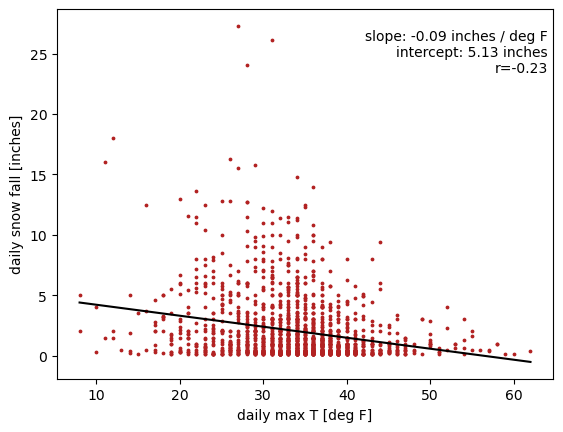

In [57]:
fig, ax = plt.subplots()
ax.scatter(ds_snow["temp_max"], ds_snow["snow_fall"], s=3, c="firebrick")
ax.plot(
    [ds_snow["temp_max"].min(), ds_snow["temp_max"].max()], 
    [lr_snow_gt0_tmax.slope * ds_snow["temp_max"].min() + lr_snow_gt0_tmax.intercept,
     lr_snow_gt0_tmax.slope * ds_snow["temp_max"].max() + lr_snow_gt0_tmax.intercept], 
    color="black")

label_text = f"""
slope: {lr_snow_gt0_tmax.slope:.02f} inches / deg F
intercept: {lr_snow_gt0_tmax.intercept:.02f} inches
r={lr_snow_gt0_tmax.rvalue:.02f}
"""

ax.text(0.99, 0.99, label_text, ha="right", va="top", transform=ax.transAxes)

ax.set_xlabel("daily max T [deg F]")
ax.set_ylabel("daily snow fall [inches]")

**Interpretation**: Compared to the case including the nonzero snowfall days, the overall negative relationship is stronger.

However, this is a case where the nature of the relationship changes with the values of the variable being regressed onto!  Notice that the scatterplot has an overall pyramid shape.  That means as the temperature increases from very cold values, you get an overall increase in snowfall, but somewhere around the freezing point of 32F the values start decreasing with further warming.

Both relationships make sense: warmer air can hold more water vapor, and so at very cold temperatures there just aren't that many water molecules available to turn into snow.  But then once the max temperature gets above freezing, that means more of the day is above freezing, which acts to inhibit snowfall.

As a bonus, let's re-do this but a separate regression for temperature values above and below freezing.

In [60]:
ds_snow_cold = ds_snow.where(ds_snow["temp_max"] < 32)

In [61]:
lr_snow_gt0_tmax_lt0 = scipy.stats.linregress(ds_snow_cold["temp_max"], ds_snow_cold["snow_fall"], nan_policy="omit")
lr_snow_gt0_tmax_lt0

LinregressResult(slope=np.float64(-0.04151249802289625), intercept=np.float64(3.967241708435825), rvalue=np.float64(-0.052481942720703244), pvalue=np.float64(0.2259841828391947), stderr=np.float64(0.03424634466379669), intercept_stderr=np.float64(0.9116889728745038))

In [63]:
ds_snow_warm = ds_snow.where(ds_snow["temp_max"] >= 32)

In [64]:
lr_snow_gt0_tmax_gt0 = scipy.stats.linregress(ds_snow_warm["temp_max"], ds_snow_warm["snow_fall"], nan_policy="omit")
lr_snow_gt0_tmax_gt0

LinregressResult(slope=np.float64(-0.07829252740923723), intercept=np.float64(4.579583838984709), rvalue=np.float64(-0.17134641760903008), pvalue=np.float64(7.775512496559319e-09), stderr=np.float64(0.01345734615857386), intercept_stderr=np.float64(0.5067952172850995))

Text(0, 0.5, 'daily snow fall [inches]')

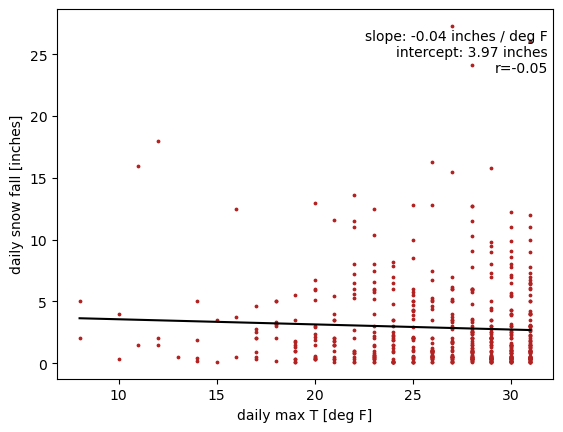

In [66]:
fig, ax = plt.subplots()
ax.scatter(ds_snow_cold["temp_max"], ds_snow_cold["snow_fall"], s=3, c="firebrick")
ax.plot(
    [ds_snow_cold["temp_max"].min(), ds_snow_cold["temp_max"].max()], 
    [lr_snow_gt0_tmax_lt0.slope * ds_snow_cold["temp_max"].min() + lr_snow_gt0_tmax_lt0.intercept,
     lr_snow_gt0_tmax_lt0.slope * ds_snow_cold["temp_max"].max() + lr_snow_gt0_tmax_lt0.intercept], 
    color="black")

label_text = f"""
slope: {lr_snow_gt0_tmax_lt0.slope:.02f} inches / deg F
intercept: {lr_snow_gt0_tmax_lt0.intercept:.02f} inches
r={lr_snow_gt0_tmax_lt0.rvalue:.02f}
"""

ax.text(0.99, 0.99, label_text, ha="right", va="top", transform=ax.transAxes)

ax.set_xlabel("daily max T [deg F]")
ax.set_ylabel("daily snow fall [inches]")

Text(0, 0.5, 'daily snow fall [inches]')

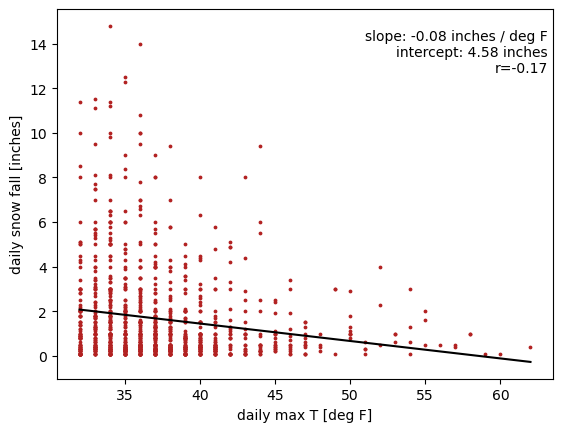

In [67]:
fig, ax = plt.subplots()
ax.scatter(ds_snow_warm["temp_max"], ds_snow_warm["snow_fall"], s=3, c="firebrick")
ax.plot(
    [ds_snow_warm["temp_max"].min(), ds_snow_warm["temp_max"].max()], 
    [lr_snow_gt0_tmax_gt0.slope * ds_snow_warm["temp_max"].min() + lr_snow_gt0_tmax_gt0.intercept,
     lr_snow_gt0_tmax_gt0.slope * ds_snow_warm["temp_max"].max() + lr_snow_gt0_tmax_gt0.intercept], 
    color="black")

label_text = f"""
slope: {lr_snow_gt0_tmax_gt0.slope:.02f} inches / deg F
intercept: {lr_snow_gt0_tmax_gt0.intercept:.02f} inches
r={lr_snow_gt0_tmax_gt0.rvalue:.02f}
"""

ax.text(0.99, 0.99, label_text, ha="right", va="top", transform=ax.transAxes)

ax.set_xlabel("daily max T [deg F]")
ax.set_ylabel("daily snow fall [inches]")

# Implement detrending

**First**, write a python function that uses linear regression to compute and return the linear trend in time of a given variable.

**Second**, write another function that calls the above function to compute the trend, and then subtracts off that trend from the original array.  The function should return this resulting *detrended* array.

**Third**, for the two variables used in the first linear regression above (block-max precip and warm-season mean temp), plot the original timeseries, the detrended timeseries, and the linear trend.  These should all go in one 2-panel figure, one panel per variable.  Include a brief summary for each variable of your interpretion of the resuls of the detrending.

**Fourth**, repeat the linear regression tasks but using the detrended timeseries.  Describe how much the results change or not.